In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL.Image

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for i in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)
print(len(physical_devices), 'devices detect')

4 devices detect


## Data augmentation 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

In [9]:
train_datagen = ImageDataGenerator( 
                                    rescale=1./255,
                                    rotation_range=10,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    horizontal_flip=True,
                                    vertical_flip=False,
                                    fill_mode='wrap'
                                 )
test_datagen = ImageDataGenerator()

In [10]:
img_size = 224
train_generator = train_datagen.flow_from_directory(
                                                    './dataset/train',
                                                    target_size=(img_size, img_size),
                                                    batch_size=1,
                                                    class_mode='categorical')

valid_generator = test_datagen.flow_from_directory(
                                                   './dataset/test',
                                                   target_size=(img_size, img_size),
                                                   batch_size=1,
                                                   class_mode='categorical',
                                                   shuffle=False)

Found 796 images belonging to 6 classes.
Found 89 images belonging to 6 classes.


## 3 ) Modelling
Data augmentation

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [12]:
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(224,224, 3))
x = net.output
x = Flatten()(x)

x = Dropout(0.5)(x)
x = Dense(200, activation='relu', name='dense1')(x)
x = BatchNormalization()(x)
x = Dense(200, activation='relu', name='dense2')(x)
x = BatchNormalization()(x)
output_layer = Dense(6, activation='softmax', name='softmax')(x)

net_final = Model(inputs=net.input, outputs=output_layer)

In [13]:
for layer in net_final.layers[:2]:
    layer.trainable = False
for layer in net_final.layers[2:]:
    layer.trainable = True

net_final.compile(optimizer=Adam(lr=5e-5, decay=0.005),
                  loss='categorical_crossentropy', metrics=['accuracy'])
print(net_final.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [14]:
History=net_final.fit_generator(train_generator, 
                        epochs=15,validation_data=valid_generator)

Epoch 1/15
 56/796 [=>............................] - ETA: 3:07 - loss: 1.7912 - accuracy: 0.2321

KeyboardInterrupt: 

In [16]:
from sklearn.metrics import accuracy_score
y_preds = net_final.predict(testData)
y_preds = np.argmax(y_preds, axis=1)
y_trues = test_labels

accuracy_score(y_preds, y_trues)

1.0

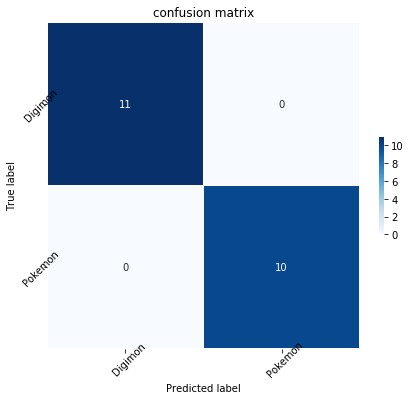

In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

## plot confusion matrix
y_preds = net_final.predict(testData)
y_preds = np.argmax(y_preds, axis=1)
y_trues = test_labels
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(classes.values()),
    yticklabels=list(classes.values()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

## 4 ) Evaluating the Model Performance

KeyError: 'val_loss'

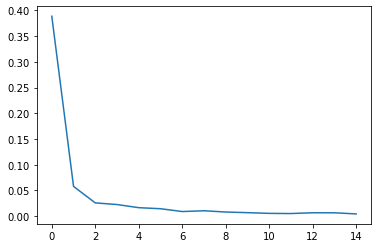

In [20]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [16]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

KeyError: 'acc'

## 6 ) Output Testing Data

In [16]:
pred =  np.argmax(net_final.predict(testData), axis=1)
newsSbmission=submission
newsSbmission["class"]=pred
newsSbmission.to_csv("submission.csv", index=False)

In [17]:
pred

array([0, 3, 4, 3, 3, 2, 0, 0, 3, 3, 1, 0, 3, 1, 1, 3, 4, 4, 1, 1, 2, 2,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 0, 1, 4, 0, 4, 4, 4, 4, 4, 2,
       3, 2, 4, 2, 3, 3, 3, 3, 1, 0, 2, 3, 0, 0, 4, 3, 0, 0, 4, 4, 1, 0,
       3, 4, 4, 1, 4, 4, 4, 4, 0, 0, 0, 4, 0, 2, 4, 1, 1, 4, 0, 3, 1, 1,
       1, 1, 0, 2, 2, 0, 2, 1, 1, 1, 1, 3, 4, 4, 4, 1, 1, 1, 1, 1, 0, 0,
       0, 2, 4, 2, 2, 1, 1, 3, 2, 1, 2, 1, 4, 2, 0, 3, 1, 1, 1, 2, 3, 1,
       4, 1, 1, 1, 1, 3, 1, 0, 0, 2, 0, 4, 1, 2, 0, 1, 2, 3, 1, 1, 1, 2,
       1, 0, 0, 1, 0, 2, 2, 3, 3, 3, 3, 3, 4, 4, 0, 1, 3, 0, 2, 0, 2, 0,
       0, 3, 4, 2, 2, 1, 0, 4, 2, 1, 3, 2, 2, 2, 0, 2, 2, 3, 3, 3, 3, 3,
       3, 0, 3, 3, 3, 2, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 2, 2, 0, 2, 2,
       3, 4, 2, 3, 2, 4, 2, 3, 3, 3, 0, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4,
       2, 2, 2, 4, 4, 4, 2, 4, 4, 2, 2, 4, 2, 3, 2, 2, 4, 4, 4, 2, 4, 3,
       4, 2, 2, 4, 4, 4, 2, 4, 4, 2, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 4,
       4, 4, 2, 3, 0, 1, 4, 2, 3, 3, 3, 3, 3, 3, 3,